<a href="https://colab.research.google.com/github/nguyenhaidang94/CTRPrediction/blob/main/CTRPrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install scikit-learn==0.24.2
!pip install seaborn

     |████████████████████████████████| 22.3 MB 1.3 MB/s 
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import scipy
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

sns.set_theme()

# Data Exploration

In [ ]:
train_data = pd.read_csv("Interview Dataset Rakuten Advertising Train Set")
test_data = pd.read_csv("Interview Dataset Rakuten Advertising Test Set")
train_data.head()

,date,zone_id,media_id,advertiser_id,campaign_id,domain,visibility,ad_id,width,height,country_ref,device,imps,clicks
0,2017-05-02 00:00:00,2794,149,3206,16034,fatsecret.com,1.0,14885,250,250,US,safari,1,0
1,2017-05-06 00:00:00,879,77,1612,8060,sfrregie.com,NaN,7126,300,250,FR,firefox,2,0
2,2017-05-07 00:00:00,1321,119,2061,10306,alberghiera.it,2.0,11696,320,50,IT,iosPhone,1,0
3,2017-05-04 00:00:00,2347,77,1605,8029,visorando.com,NaN,5837,1000,90,FR,firefox,1,0
4,2017-05-02 00:00:00,931,90,1604,8023,pblv-plusbellelavie.fr,NaN,7414,300,250,FR,firefox,1,0


In [ ]:
print("Number of samples in train:", train_data.shape[0])
print("Number of features in train:", train_data.shape[1])
print("Missing values by features:")
print(train_data.isnull().sum())

print("\nNumber of samples in test:", test_data.shape[0])
print("Number of features in test:", test_data.shape[1])
print("Missing values by features:")
print(test_data.isnull().sum())

Number of samples in train: 5395051
Number of features in train: 14
Missing values by features:
date                   0
zone_id                0
media_id               0
advertiser_id          0
campaign_id            0
domain             95533
visibility       2617589
ad_id                  0
width                  0
height                 0
country_ref            0
device                 0
imps                   0
clicks                 0
dtype: int64

Number of samples in test: 2019086
Number of features in test: 13
Missing values by features:
date                   0
zone_id                0
media_id               0
advertiser_id          0
campaign_id            0
domain             33075
visibility       1032067
ad_id                  0
width                  0
height                 0
country_ref            0
device                 0
imps                   0
dtype: int64


There are missing values in two features "domain" and "visibility".

In [ ]:
# compute click-through rate
train_data["ctr"] = train_data["clicks"] / train_data["imps"]

In [ ]:
print("data description:")
train_data.describe()

data description:


,zone_id,media_id,advertiser_id,campaign_id,visibility,ad_id,width,height,imps,clicks,ctr
count,5.395051e+06,5.395051e+06,5.395051e+06,5.395051e+06,2.777462e+06,5.395051e+06,5.395051e+06,5.395051e+06,5.395051e+06,5.395051e+06,5.395051e+06
mean,1.058986e+03,8.625012e+01,1.642347e+03,8.213575e+03,1.559608e+00,6.769758e+03,4.388122e+02,2.712985e+02,3.463554e+00,7.590568e-02,2.352945e-02
std,6.130215e+02,2.883187e+01,4.994399e+02,2.497179e+03,4.964342e-01,3.529216e+03,2.883020e+02,2.115282e+02,3.100167e+01,1.310036e+00,1.421493e-01
min,1.000000e+00,1.000000e+00,0.000000e+00,2.000000e+00,1.000000e+00,1.000000e+00,1.900000e+01,1.100000e+01,1.000000e+00,0.000000e+00,0.000000e+00
25%,7.000000e+02,7.400000e+01,1.604000e+03,8.023000e+03,1.000000e+00,4.768000e+03,3.000000e+02,9.000000e+01,1.000000e+00,0.000000e+00,0.000000e+00
50%,8.690000e+02,8.700000e+01,1.611000e+03,8.059000e+03,2.000000e+00,6.826000e+03,3.000000e+02,2.500000e+02,1.000000e+00,0.000000e+00,0.000000e+00
75%,1.183000e+03,9.400000e+01,1.627000e+03,8.135000e+03,2.000000e+00,9.719000e+03,7.280000e+02,2.500000e+02,2.000000e+00,0.000000e+00,0.000000e+00
max,2.930000e+03,1.870000e+02,3.210000e+03,1.605400e+04,2.000000e+00,1.531800e+04,1.800000e+03,1.000000e+03,1.820300e+04,6.940000e+02,1.000000e+00


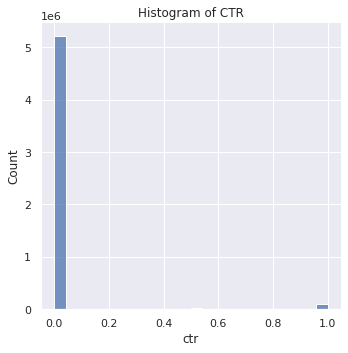

In [ ]:
g = sns.displot(train_data, x="ctr")
g.set(title="Histogram of CTR")

In [ ]:
print("Ratio of CTR=0:", len(train_data[train_data["ctr"]==0])/len(train_data))
print("Number of samples with CTR non-zero:", len(train_data[train_data["ctr"]!=0]))

Ratio of CTR=0: 0.9626937724963119
Number of samples with CTR non-zero: 201269


The data is clearly imbalanced

[Text(0.5, 1.0, 'Number of samples by countries')]

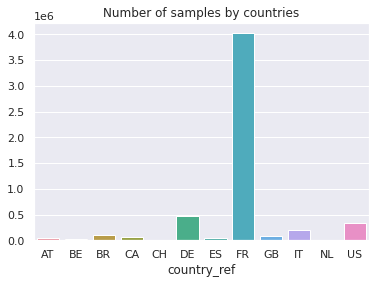

In [ ]:
plot_data = train_data.groupby(by="country_ref").size()
g = sns.barplot(x=plot_data.index, y=plot_data.values)
g.set(title="Number of samples by countries")

[Text(0.5, 1.0, 'CTR by countries')]

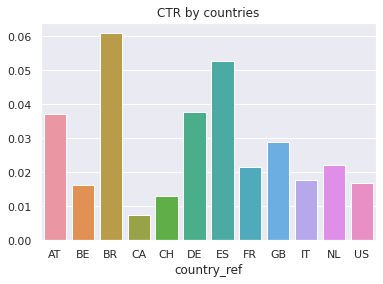

In [ ]:
plot_data = train_data.groupby(by="country_ref").ctr.agg("mean")
g = sns.barplot(x=plot_data.index, y=plot_data.values)
g.set(title="CTR by countries")

[Text(0.5, 1.0, 'Number of samples by devices')]

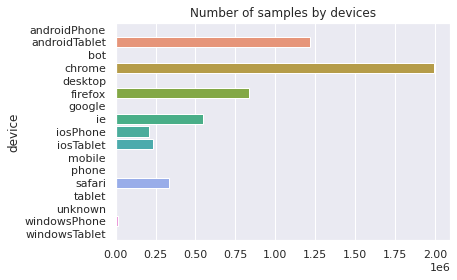

In [ ]:
plot_data = train_data.groupby(by="device").size()
g = sns.barplot(y=plot_data.index, x=plot_data.values, orient="h")
g.set(title="Number of samples by devices")

[Text(0.5, 1.0, 'CTR by devices')]

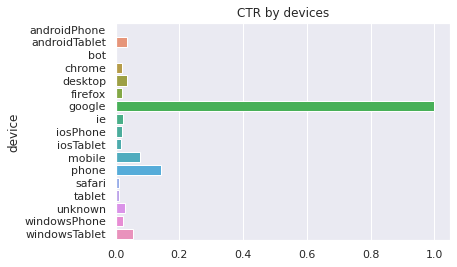

In [ ]:
plot_data = train_data.groupby(by="device").ctr.agg("mean")
g = sns.barplot(y=plot_data.index, x=plot_data.values, orient="h")
g.set(title="CTR by devices")

# Pre-processing

In [ ]:
# treat missing values as another category
def fill_missing_values(df):
  # fill missing values in domain by unknown
  df["domain"] = df["domain"].fillna(value="unknown")
  df["visibility"] = df["visibility"].fillna(value=3)
  return df

train_data = fill_missing_values(train_data)
test_data = fill_missing_values(test_data)

# Feature Selection

In [ ]:
categorical_features = ["date", "zone_id", "media_id", "advertiser_id", "campaign_id",
                        "domain", "visibility", "ad_id", "country_ref", "device"]
print("Number of unique values by features")
list_unique_values = []
for feature in categorical_features:
  n_unique_values = len(train_data[feature].unique())
  list_unique_values.append(n_unique_values)
  print(f"Feature: {feature}, unique values: {n_unique_values}")

Number of unique values by features
Feature: date, unique values: 8
Feature: zone_id, unique values: 2910
Feature: media_id, unique values: 187
Feature: advertiser_id, unique values: 119
Feature: campaign_id, unique values: 503
Feature: domain, unique values: 82016
Feature: visibility, unique values: 3
Feature: ad_id, unique values: 15184
Feature: country_ref, unique values: 12
Feature: device, unique values: 17


There are categorical features with high number of unique values, we can drop them, keep visibility, country_ref and device.

In [ ]:
# add feature area
train_data["area"] = train_data["width"] * train_data["height"]
# encode categorical features then stack with numerical features
selected_categorical_features = ["visibility", "country_ref", "device"]
numerical_features = ["width", "height", "area", "imps"]
X_train = train_data[selected_categorical_features]
ohe = OneHotEncoder(drop=None, handle_unknown="ignore")
X_train_ohe = ohe.fit_transform(X_train)
X_train_ohe = scipy.sparse.hstack([X_train_ohe, scipy.sparse.csr_matrix(train_data[numerical_features])])
Y_train = train_data["ctr"].values

In [ ]:
rf_regressor = RandomForestRegressor(n_estimators=10, n_jobs=-1, max_depth=3)
rf_regressor.fit(X_train_ohe, Y_train)
print("R-squared:", rf_regressor.score(X_train_ohe, Y_train))
print("Feature importance:")
print(rf_regressor.feature_importances_)

R-squared: 0.012981864336045312
Feature importance:
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.2139478  0.
 0.         0.         0.         0.         0.03333312 0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.23331171 0.0808306  0.42822013 0.01035665]


The first 15 values represent the feature visibility and country_ref. They are zeros meaning there is no contribution in the dependence variable. We can remove them.

In [ ]:
def feature_transform(df, ohe=None):
  df["area"] = df["width"] * df["height"]
  selected_categorical_features = ["device"]
  numerical_features = ["width", "height", "area", "imps"]
  X = df[selected_categorical_features]
  if ohe == None:
    ohe = OneHotEncoder(drop=None, handle_unknown="ignore")
    ohe.fit(X)
  X_ohe = ohe.transform(X)
  X_ohe = scipy.sparse.hstack([X_ohe, scipy.sparse.csr_matrix(df[numerical_features])])
  return X_ohe, ohe

# Upper bound loss

In [ ]:
def loss(clicks, imps, pred_ctr):
  pred_ctr[pred_ctr == 0] = 1e-10
  pred_ctr[pred_ctr == 1] = 1 - 1e-10
  nominator = np.sum(np.multiply(clicks, np.log(pred_ctr)) + np.multiply(imps - clicks, np.log(1 - pred_ctr)))
  denominator = np.sum(imps)
  return - nominator / denominator

def plot_loss(clicks, imps):
  n_samples = 9
  list_clicks = np.empty((n_samples, 1))
  list_clicks[:, 0] = clicks
  list_imps = np.empty((n_samples, 1))
  list_imps[:, 0] = imps
  pred_ctr = np.arange(0.1, 1, 0.1).reshape((-1, 1))
  loss_vals = [loss(list_clicks[i,:], list_imps[i,:], pred_ctr[i,:]) for i in range(n_samples)]
  g = sns.lineplot(x=np.ravel(pred_ctr), y=loss_vals)
  g.set(title=f"imps={imps}, clicks={clicks}", xlabel="predicted ctr", ylabel="loss")

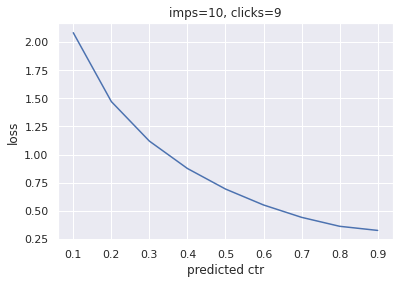

In [ ]:
plot_loss(clicks=9, imps=10)

The loss function minimize the difference between true CTR and predicted CTR, it is stronger than MSE.

In [ ]:
print("The upper bound loss in training set when predicting all CTRs equal zeros")
ctr_pred = np.ones(train_data.shape[0]) * 1e-10
print(loss(train_data["clicks"].values, train_data["imps"].values, ctr_pred))

The upper bound loss in training set when predicting all CTRs equal zeros
0.5046241637291214


# Baseline model with Linear Regression

In [ ]:
X_train, ohe = feature_transform(train_data)
X_test, _ = feature_transform(test_data, ohe)

ctr = train_data["ctr"].values
# avoid devide by zero
ctr[ctr == 0] = 1e-10
ctr[ctr == 1] = 1 - 1e-10
Y_train = np.log(ctr / (1 - ctr))

In [ ]:
# search for best params by R square
params = {"alpha": [1, 3, 5]}
lr_model = GridSearchCV(estimator=Ridge(fit_intercept=False), param_grid=params,
                        cv=5, n_jobs=-1, refit=True)
lr_model.fit(X_train, Y_train)
print("best params:", lr_model.best_params_)
print("best score:", lr_model.best_score_)

# compute loss in training set
Y_train_pred = lr_model.predict(X_train)
# convert to probability by sigmoid function
Y_train_pred = 1 / (1 + np.exp(-Y_train_pred))
# evaluate by loss in training set
training_loss = loss(train_data["clicks"].values, train_data["imps"].values, Y_train_pred)
print("Loss in training set:", training_loss)
print("Number of predicted CTR in training set greater than 0.3:", len(Y_train_pred[Y_train_pred > 0.3]))

/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


best params: {'alpha': 3}
best score: -1.0707149984070847
Loss in training set: 0.39654088787556513
Number of predicted CTR in training set greater than 0.3: 0


R-squared is negative meaning that the model is worse than predicting $\hat y = \bar y$

In [ ]:
Y_test_prd = lr_model.predict(X_test)
# convert to probability by sigmoid function
ctr_test_prd = 1 / (1 + np.exp(-Y_test_prd))
np.savetxt("lr_result.txt", ctr_test_prd)

# Random Forest Regression

In [ ]:
X_train, ohe = feature_transform(train_data)
X_test, _ = feature_transform(test_data, ohe)
Y_train = train_data["ctr"].values

In [ ]:
#train one tree to see how much the depth is
tree_regressor = DecisionTreeRegressor()
tree_regressor.fit(X_train, Y_train)
print("Depth of tree:", tree_regressor.tree_.max_depth)

Depth of tree: 56


In [ ]:
# fix number of trees and search for the max_depth
estimator = RandomForestRegressor(n_estimators=10, n_jobs=-1)
params = {"max_depth": [5, 10, 20]}
rf_regressor = GridSearchCV(estimator=estimator, param_grid=params, cv=5,
                            n_jobs=-1, refit=False)
rf_regressor.fit(X_train, Y_train)
print("best params:", rf_regressor.best_params_)
print("best r-squared:", rf_regressor.best_score_)

best params: {'max_depth': 10}
best r-squared: 0.021744724427840346


In [ ]:
# fix max_depth and search for the number of trees
estimator = RandomForestRegressor(max_depth=10, n_jobs=-1)
params = {"n_estimators": [50, 100]}
rf_regressor = GridSearchCV(estimator=estimator, param_grid=params, cv=5,
                            n_jobs=-1, refit=False)
rf_regressor.fit(X_train, Y_train)
print("best params:", rf_regressor.best_params_)
print("best r-squared:", rf_regressor.best_score_)

best params: {'n_estimators': 20}  
best r-squared: 0.019211792063558296  
best params: {'n_estimators': 100}  
best r-squared: 0.019258856924289237

In [ ]:
rf_regressor = RandomForestRegressor(n_estimators=100, max_depth=10, n_jobs=-1)
rf_regressor.fit(X_train, Y_train)
print("R-squared score:", rf_regressor.score(X_train, Y_train))
Y_train_pred = rf_regressor.predict(X_train)
training_loss = loss(train_data["clicks"].values, train_data["imps"].values, Y_train_pred)
print("Loss in training set:", training_loss)
print("Number of predicted CTR in training set greater than 0.5:", len(Y_train_pred[Y_train_pred > 0.5]))

R-squared score: 0.022283318145126962
Loss in training set: 0.09394393115748326
Number of predicted CTR in training set greater than 0.5: 515


The result is better than linear regression model. There are predicted CTRs which are greater than 0.5.

In [ ]:
Y_test_prd = rf_regressor.predict(X_test)
np.savetxt("rf_result.txt", Y_test_prd)

# XGBoost

In [ ]:
import xgboost as xgb
from sklearn.metrics import r2_score

In [ ]:
def feature_transform(df, ohe=None):
  df["area"] = df["width"] * df["height"]
  selected_categorical_features = ["media_id", "advertiser_id", "device",
                                   "country_ref", "visibility"]
  numerical_features = ["width", "height", "area", "imps"]
  X = df[selected_categorical_features]
  if ohe == None:
    ohe = OneHotEncoder(drop=None, handle_unknown="ignore")
    ohe.fit(X)
  X_ohe = ohe.transform(X)
  X_ohe = scipy.sparse.hstack([X_ohe, scipy.sparse.csr_matrix(df[numerical_features])])
  return X_ohe, ohe

In [ ]:
X_train, ohe = feature_transform(train_data)
X_test, _ = feature_transform(test_data, ohe)
Y_train = train_data["ctr"].values
print(X_train.shape)
print(X_test.shape)

(5395051, 342)
(2019086, 342)


In [ ]:
# tune the number of trees and max depth
estimater = xgb.XGBRegressor(learning_rate=0.3, objective="reg:logistic",
                             tree_method="gpu_hist", n_jobs=-1, booster="gbtree")
params = {"n_estimators": [100, 150, 200], "max_depth": [5, 7, 10]}
gridsearch_cv = GridSearchCV(estimater, param_grid=params, scoring="r2",
                             cv=5, n_jobs=-1, refit=False)
gridsearch_cv.fit(X_train, Y_train)
print("best params:", gridsearch_cv.best_params_)
print("best r-squared:", gridsearch_cv.best_score_)

/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


best params: {'max_depth': 10, 'n_estimators': 200}
best r-squared: 0.07168975337437919


In [ ]:
# tune learning_rate
estimater = xgb.XGBRegressor(n_estimators=200, max_depth=10, objective="reg:logistic",
                             tree_method="gpu_hist", n_jobs=-1)
params = {"learning_rate": [0.1, 0.3, 0.4]}
gridsearch_cv = GridSearchCV(estimater, param_grid=params, scoring="r2",
                             cv=5, n_jobs=-1, refit=False)
gridsearch_cv.fit(X_train, Y_train)
print("best params:", gridsearch_cv.best_params_)
print("best r-squared:", gridsearch_cv.best_score_)

best params: {'learning_rate': 0.4}
best r-squared: 0.07186517609181169


In [ ]:
# tune regularization
estimater = xgb.XGBRegressor(n_estimators=200, max_depth=10, learning_rate=0.4,
                             objective="reg:logistic", tree_method="gpu_hist", n_jobs=-1, booster="gbtree")
params = {"reg_lambda": [1, 3, 5]}
gridsearch_cv = GridSearchCV(estimater, param_grid=params, scoring="r2",
                             cv=5, n_jobs=-1, refit=False)
gridsearch_cv.fit(X_train, Y_train)
print("best params:", gridsearch_cv.best_params_)
print("best r-squared:", gridsearch_cv.best_score_)

best params: {'reg_lambda': 3}
best r-squared: 0.07201304220823321


In [ ]:
xgb_regressor = xgb.XGBRegressor(n_estimators=200, max_depth=10, learning_rate=0.4, reg_lambda=3,
                                 objective="reg:logistic", tree_method="gpu_hist", n_jobs=-1, booster="gbtree")
xgb_regressor.fit(X_train, Y_train)
Y_train_pred = xgb_regressor.predict(X_train)
print("R-squared:", r2_score(Y_train, Y_train_pred))
print("Loss:", loss(train_data["clicks"].values, train_data["imps"].values, Y_train_pred))
print("Number of predicted CTR in training set greater than 0.5:", len(Y_train_pred[Y_train_pred > 0.5]))

R-squared: 0.08477285036702309
Loss: 0.081893303468141
Number of predicted CTR in training set greater than 0.5: 4069


XGBoost has better performance than Random Forest

In [ ]:
Y_test_prd = xgb_regressor.predict(X_test)
np.savetxt("xgb_result.txt", Y_test_prd)

# Factorization Machine

In [ ]:
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.preprocessing import OrdinalEncoder
import itertools
import tensorflow as tf
from keras.layers import Input, Embedding, Dense, Flatten, Activation, Dot, Add
from keras.models import Model
from keras.regularizers import l2 as l2_reg
from keras.losses import Loss

In [ ]:
train_data["area"] = train_data["width"] * train_data["height"]
numerical_features = ["width", "height", "area", "imps"]
train_data[numerical_features].describe()

,width,height,area,imps
count,5.395051e+06,5.395051e+06,5.395051e+06,5.395051e+06
mean,4.388122e+02,2.712985e+02,1.074521e+05,3.463554e+00
std,2.883020e+02,2.115282e+02,2.134108e+05,3.100167e+01
min,1.900000e+01,1.100000e+01,2.090000e+02,1.000000e+00
25%,3.000000e+02,9.000000e+01,6.552000e+04,1.000000e+00
50%,3.000000e+02,2.500000e+02,7.500000e+04,1.000000e+00
75%,7.280000e+02,2.500000e+02,7.500000e+04,2.000000e+00
max,1.800000e+03,1.000000e+03,1.800000e+06,1.820300e+04


In [ ]:
def fm_feature_transform(df, cat_features, num_features, ode=None, kbd=None,
                         n_bins=None):
  df["area"] = df["width"] * df["height"]
  X_cat = df[cat_features].values
  if ode == None:
    ode = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=np.nan)
    ode.fit(X_cat)
  X_cat = ode.transform(X_cat)

  X_num = df[num_features].values
  if kbd == None:
    kbd = KBinsDiscretizer(n_bins=n_bins, encode="ordinal")
    kbd.fit(X_num)
  X_num = kbd.transform(X_num)
  X = np.hstack((X_cat, X_num))
  return X, ode, kbd

In [ ]:
cat_features = ["media_id", "advertiser_id", "device", "country_ref", "visibility"]
num_features = ["width", "height", "area", "imps"]
# use 10 bins for each numerical feature
n_bins = [10, 10, 10, 10]
X_train, ode, kbd = fm_feature_transform(train_data, cat_features, num_features,
                                         ode=None, kbd=None, n_bins=n_bins)
X_test,_,_ = fm_feature_transform(test_data, cat_features, num_features, ode, kbd)
max_cat_features = [len(train_data[f].unique()) for f in cat_features]
max_features = np.concatenate((max_cat_features, kbd.n_bins_))

Y_train = train_data["ctr"].values
print(X_train.shape)
print(X_test.shape)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:222: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  'decreasing the number of bins.' % jj)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:222: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 1 are removed. Consider decreasing the number of bins.
  'decreasing the number of bins.' % jj)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:222: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 2 are removed. Consider decreasing the number of bins.
  'decreasing the number of bins.' % jj)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:222: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 3 are removed. Consider decreasing the number of bins.
  'decreasing the number of bins.

(5395051, 9)
(2019086, 9)


In [ ]:
class CustomLoss(Loss):
  def call(self, y_true, y_pred):
    ln_y_pred = tf.math.log(y_pred)
    one_minus_y_true = tf.math.subtract(1.0, y_true)
    ln_1_minus_y_pred = tf.math.log(tf.math.subtract(1.0, y_pred))
    
    first_term = tf.math.negative(tf.math.multiply(y_true, ln_y_pred))
    second_term = tf.math.negative(tf.math.multiply(one_minus_y_true, ln_1_minus_y_pred))
    return tf.reduce_mean(first_term + second_term)

def build_model(max_features, embedding_dim=8, l2=0.0, l2_fm=0.0):
  inputs = []
  flatten_layers=[]
  columns = range(len(max_features))
  for c in columns:
    inputs_c = Input(shape=(1,), dtype='int32', name='input_%s'%c)
    num_c = max_features[c]
    embed_c = Embedding(num_c, embedding_dim, input_length=1, name='embed_%s'%c,
                        embeddings_regularizer=l2_reg(l2_fm))(inputs_c)
    flatten_c = Flatten()(embed_c)
    inputs.append(inputs_c)
    flatten_layers.append(flatten_c)

  fm_layers = []
  for emb1, emb2 in itertools.combinations(flatten_layers, 2):
    dot_layer = Dot(axes=1)([emb1, emb2])
    fm_layers.append(dot_layer)

  for c in columns:
    num_c = max_features[c]
    embed_c = Embedding(num_c, 1, input_length=1, name = 'linear_%s'%c,
                        embeddings_regularizer=l2_reg(l2))(inputs[c])
    flatten_c = Flatten()(embed_c)
    fm_layers.append(flatten_c)

  flatten = Add()(fm_layers)
  outputs = Activation('sigmoid', name='outputs')(flatten)

  model = Model(inputs=inputs, outputs=outputs)
  model.compile(optimizer="adam", loss=CustomLoss())
  return model

In [ ]:
model = build_model(max_features, embedding_dim=8, l2=0.01, l2_fm=0.01)
# model.summary()

In [ ]:
X_train_ = [X_train[:,i] for i in range(X_train.shape[1])]
model.fit(X_train_, Y_train, batch_size=512, epochs=3, validation_split=0.3)

Epoch 1/3
7377/7377 [==============================] - 96s 12ms/step - loss: 0.1668 - val_loss: 0.1563
Epoch 2/3
7377/7377 [==============================] - 88s 12ms/step - loss: 0.1561 - val_loss: 0.1563
Epoch 3/3
7377/7377 [==============================] - 89s 12ms/step - loss: 0.1561 - val_loss: 0.1563


In [ ]:
Y_train_pred = model.predict(X_train_, batch_size=512)
Y_train_pred = np.ravel(Y_train_pred)
print("Loss:", loss(train_data["clicks"].values, train_data["imps"].values, Y_train_pred))
print("Number of predicted CTR in training set greater than 0.5:", len(Y_train_pred[Y_train_pred > 0.5]))

Loss: 0.119994880966001
Number of predicted CTR in training set greater than 0.5: 0


In [ ]:
X_test_ = [X_test[:,i] for i in range(X_test.shape[1])]
Y_test_pred = model.predict(X_test_, batch_size=512)
Y_test_pred = np.ravel(Y_test_pred)
np.savetxt("fm_result.txt", Y_test_prd)